## Setup a classification experiment

In [3]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

def rfecv_feats(X_train,y_train,folds,model):

    min_features_to_select = 1
    
    if model == "svc": model = SVC(kernel='linear')
    elif model == "lr": model = LogisticRegression(penalty='l2', solver='sag')
    elif model == "ebm": model = ExplainableBoostingClassifier(random_state=1, n_jobs=-1)

    rfecv = RFECV(estimator=model, step=0.05, cv=StratifiedKFold(folds),
                  scoring='roc_auc',
                  min_features_to_select=1)
    rfecv = rfecv.fit(X_train, y_train)

    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(
        range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
        rfecv.grid_scores_,
    )
    plt.show()
        
    return X_train.iloc[:,rfecv.support_].columns.to_list()

In [4]:
from imblearn.over_sampling import SMOTE

In [178]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = pd.read_csv('bmi_hormones.csv', index_col = 0)
X = X.fillna(X.loc[:,'BMI kg/m2'].mean())
X.index.name = None
y = X.loc[:,"endocrine response"]
y = y.map({'good': 1, 'poor': 0}).astype(int)

#X = X.drop(["endocrine response",'? Ki67'], axis = 1)

#X = X.loc[:,["Q pre Rx Ki67","Post Rx TILs %"]]

#X = X.loc[:,["Post Rx TILs %","Q pre Rx Ki67"]]

no_pre_TILs = ["MBN-52","MBN-54","MBN-55","MBN-59","MBN-60","MBN-61","MBN-62","MBN-63","MBN-65","MBN-67","MBN-68","MBN-70","MBN-71",
               "MBN-72","MBN-77","MBN-76","MBN-78","MBN-79","MBN-80","MBN-82","MBN-84","MBN-85","MBN-86","MBN-88",
               "MBN-89","MBN-91","MBN-93","MBN-95"]

X_pre_TILs = X.drop(no_pre_TILs)
y_pre_TILs = y.drop(no_pre_TILs)

X_pre_TILs = X_pre_TILs.iloc[:,:-6]

X_pre_TILs = X_pre_TILs.drop(["endocrine response",'? Ki67',"Q post Rx Ki67","Type","Ethnicity","Post Rx TILs %","Post Rx ER Percent","Post Rx ER","Post Rx PR Percent","Post Rx PR"], axis = 1)

X_pre_TILs = X_pre_TILs.loc[:,['Q pre Rx Ki67','Grade ', 'Size','total_nodes',"Pre Rx TILs %"]]

# Pre treatment only
X = X.drop(["endocrine response",'? Ki67',"Q post Rx Ki67","Type","Ethnicity","Pre Rx TILs %","Post Rx ER Percent","Post Rx ER","Post Rx PR Percent","Post Rx PR"], axis = 1)

seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed, stratify=y)

print(X_pre_TILs.columns)

X = X.iloc[:,:-6]
print(X.columns)

X = X.drop(["MBN-55","MBN-62"])
y = y.drop(["MBN-55","MBN-62"])

print(y.value_counts())

#X.loc[:,"Pre Rx HER2"] = X.loc[:,"Pre Rx HER2"].map({'neg': 0, 'pos': 1}).astype(int)
#X_pre_TILs.loc[:,"Pre Rx HER2"] = X_pre_TILs.loc[:,"Pre Rx HER2"].map({'neg': 0, 'pos': 1}).astype(int)

Index(['Q pre Rx Ki67', 'Grade ', 'Size', 'total_nodes', 'Pre Rx TILs %'], dtype='object')
Index(['age at diagnosis', 'BMI kg/m2', 'Q pre Rx Ki67', 'Grade ', 'Size',
       'nodes', 'total_nodes', 'Post Rx TILs %', 'Pre Rx ER Percent',
       'Pre Rx ER', 'Pre Rx PR Percent', 'Pre Rx PR', 'Pre Rx HER2'],
      dtype='object')
1    39
0    22
Name: endocrine response, dtype: int64


In [124]:
X_good = X_pre_TILs[y_pre_TILs==1]
X_poor = X_pre_TILs[y_pre_TILs==0]

In [140]:
X_good.iloc[:,0]

MBN-49    54.0
MBN-58     5.9
MBN-1     18.6
MBN-5     26.6
MBN-6     21.6
MBN-8     27.8
MBN-16    31.1
MBN-15     7.7
MBN-18    18.1
MBN-23     5.7
MBN-19    45.0
MBN-24    19.0
MBN-20    33.0
MBN-25    39.0
MBN-27    18.8
MBN-28     6.2
MBN-26    19.0
MBN-30     4.0
MBN-33     3.1
MBN-34     8.4
MBN-39    11.1
MBN-40    17.4
MBN-41    22.9
Name: Q pre Rx Ki67, dtype: float64

In [149]:
np.mean(X_good)

Q pre Rx Ki67    20.173913
Grade             1.869565
Size             15.217391
total_nodes       7.043478
Pre Rx TILs %     4.391304
dtype: float64

In [150]:
np.mean(X_poor)

Q pre Rx Ki67    13.583333
Grade             1.833333
Size             19.625000
total_nodes       3.500000
Pre Rx TILs %    17.750000
dtype: float64

In [151]:
X_pre_TILs.loc["MBN-8",:]

Q pre Rx Ki67    27.8
Grade             2.0
Size             18.0
total_nodes       1.0
Pre Rx TILs %    10.0
Name: MBN-8, dtype: float64

In [179]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import RocCurveDisplay
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from math import floor
from tqdm import tqdm
from sklearn.decomposition import PCA
import numpy as np
from sklearn.linear_model import LogisticRegression
import warnings
import shap
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
warnings.filterwarnings(action='ignore')

seed = 1

folds = 12

kfold = RepeatedStratifiedKFold(n_splits=folds, n_repeats=10, random_state=121)

clinical_scores = np.zeros((35,10))

i = 0

for train_index, test_index in tqdm(kfold.split(X_pre_TILs, y_pre_TILs), total=kfold.get_n_splits(), desc="k-fold"):
    
    X_train, X_test = X_pre_TILs.iloc[train_index,:], X_pre_TILs.iloc[test_index,:]
    y_train, y_test = y_pre_TILs[train_index], y_pre_TILs[test_index]
    
#     sampling = RandomUnderSampler()
#     X_over, y_over = sampling.fit_resample(X_train,y_train)
    
    #features = rfecv_feats(X_train,y_train,5,"lr")
    
#     print(features)
    
#     X_over = X_over.loc[:,features]
#     X_test = X_test.loc[:,features]
    
    model = SVC(probability=True,kernel="sigmoid")
    #model = LogisticRegression(penalty='l2', solver='sag')
    model.fit(X_train,y_train)
    
#     for z,val in enumerate(test_index):
#         if X_pre_TILs.index[val] == "MBN-23":
#             explainer = shap.LinearExplainer(model,X_test)
#             shap_values = explainer(X_test)
#             shap.summary_plot(shap_values, X_test, feature_names=X_pre_TILs.columns)
#             display(shap.force_plot(shap_values[z]))

    for pred,label in zip(model.predict_proba(X_test),test_index):
        clinical_scores[label][floor(i/folds)] = pred[1]
    
#     l = 0
#     for a, b in zip(model.predict_proba(X_test), y_test):
#         if str(X_pre_TILs.index[test_index[l]]) == "MBN-17":
#             print("Patient " + str(X_pre_TILs.index[test_index[l]]) + " Prediction: "+str(a)+" Real: "+str(b)+"\n")
#         l += 1
    i += 1

k-fold: 100%|████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 257.20it/s]


In [180]:
def listify(p):
    y_list = []
    for val in p: y_list.append([val])
    return y_list

In [181]:
mean = np.mean(clinical_scores, axis=1)
    
labelled_scores = np.append(clinical_scores, listify(mean), axis=1)
labelled_scores_mean = np.append(labelled_scores, listify(y_pre_TILs), axis = 1)

<AxesSubplot:>

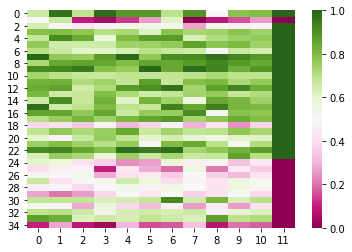

In [182]:
import seaborn as sns

sns.heatmap(labelled_scores_mean,cmap="PiYG")

0.8285714285714286
[[21  4]
 [ 2  8]]


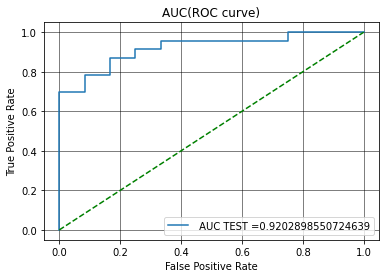

In [183]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

#train_fpr, train_tpr, tr_thresholds = roc_curve(y,methylation_scores_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_pre_TILs,labelled_scores_mean[:,-2])

plt.grid()

acc = []
for val in labelled_scores_mean[:,-2]:
    acc.append(0) if val < 0.5 else acc.append(1)

print(accuracy_score(y_pre_TILs, acc))
print(confusion_matrix(acc, y_pre_TILs, labels = [1,0]))

#plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [103]:
matched = ["MBN-5","MBN-41","MBN-1","MBN-17","MBN-44","MBN-2","MBN-11","MBN-31","MBN-47",
                   "MBN-42","MBN-8","MBN-20","MBN-25","MBN-26","MBN-6","MBN-16","MBN-18","MBN-23","MBN-28","MBN-39"]

y_common = y_pre_TILs.loc[matched]

matched_scores = np.zeros((20,12))

for row,label in zip(labelled_scores_mean,y_pre_TILs.index):
    if label in matched:
        k = 0
        for entry in row:
            matched_scores[matched.index(label)][k] = entry
            k += 1

0.85
[[13  3]
 [ 0  4]]


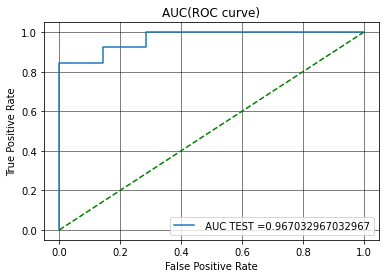

In [104]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix


#train_fpr, train_tpr, tr_thresholds = roc_curve(y,methylation_scores_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_common,matched_scores[:,-2])

plt.grid()

acc = []
for val in matched_scores[:,-2]:
    acc.append(0) if val < 0.5 else acc.append(1)

print(accuracy_score(y_common, acc))
print(confusion_matrix(acc, y_common, labels = [1,0]))

#plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [123]:
matched_scores

array([[0.69031021, 0.86539351, 0.82496207, 0.62871568, 0.75888757,
        0.77111587, 0.85086111, 0.57015953, 0.66671748, 0.69096527,
        0.73180883, 1.        ],
       [0.67649108, 0.70407406, 0.71835648, 0.71015593, 0.69208393,
        0.87431174, 0.65765782, 0.60473429, 0.66259202, 0.84295838,
        0.71434157, 1.        ],
       [0.69689932, 0.8178605 , 0.76435188, 0.69691341, 0.79291876,
        0.65981543, 0.74585649, 0.72593455, 0.79516344, 0.7074452 ,
        0.7403159 , 1.        ],
       [0.49332276, 0.44068923, 0.51043555, 0.51867573, 0.52569291,
        0.51049525, 0.45093403, 0.52266666, 0.22361665, 0.47137542,
        0.46679042, 0.        ],
       [0.83296448, 0.85325885, 0.6411113 , 0.66666369, 0.65216007,
        0.65344391, 0.60524418, 0.62768983, 0.76639532, 0.68688747,
        0.69858191, 0.        ],
       [0.55811024, 0.5       , 0.47463148, 0.53310257, 0.32993594,
        0.54300238, 0.63962389, 0.42184502, 0.4693695 , 0.5       ,
        0.4969621 ,

In [105]:
te_thresholds

array([1.86442097, 0.86442097, 0.71434157, 0.69858191, 0.68543027,
       0.67954267, 0.61835621, 0.21363297])

In [106]:
def occ(scores,thresh):
    
    occ = []

    for row in scores[:,:-2]:
        k = 0
        for item in row:
            if item >= thresh: k+=1
            
        occ.append(k/10)
        
    return occ

In [110]:
occ_clinical = occ(matched_scores,0.67)

In [171]:
matched_scores

array([[0.69031021, 0.86539351, 0.82496207, 0.62871568, 0.75888757,
        0.77111587, 0.85086111, 0.57015953, 0.66671748, 0.69096527,
        0.73180883, 1.        ],
       [0.67649108, 0.70407406, 0.71835648, 0.71015593, 0.69208393,
        0.87431174, 0.65765782, 0.60473429, 0.66259202, 0.84295838,
        0.71434157, 1.        ],
       [0.69689932, 0.8178605 , 0.76435188, 0.69691341, 0.79291876,
        0.65981543, 0.74585649, 0.72593455, 0.79516344, 0.7074452 ,
        0.7403159 , 1.        ],
       [0.49332276, 0.44068923, 0.51043555, 0.51867573, 0.52569291,
        0.51049525, 0.45093403, 0.52266666, 0.22361665, 0.47137542,
        0.46679042, 0.        ],
       [0.83296448, 0.85325885, 0.6411113 , 0.66666369, 0.65216007,
        0.65344391, 0.60524418, 0.62768983, 0.76639532, 0.68688747,
        0.69858191, 0.        ],
       [0.55811024, 0.5       , 0.47463148, 0.53310257, 0.32993594,
        0.54300238, 0.63962389, 0.42184502, 0.4693695 , 0.5       ,
        0.4969621 ,

In [114]:
occ_clinical

[0.7,
 0.7,
 0.9,
 0.0,
 0.4,
 0.0,
 0.2,
 0.2,
 0.0,
 0.0,
 0.1,
 0.7,
 0.5,
 1.0,
 0.8,
 1.0,
 1.0,
 0.6,
 0.8,
 0.8]

0.95
[[12  0]
 [ 1  7]]


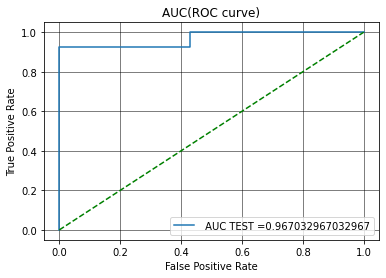

In [116]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix

occ_clinical = occ(matched_scores,0.67)

#train_fpr, train_tpr, tr_thresholds = roc_curve(y,methylation_scores_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_common,occ_clinical)

plt.grid()

acc = []
for val in occ_clinical:
    acc.append(0) if val < 0.5 else acc.append(1)

print(accuracy_score(y_common, acc))
print(confusion_matrix(acc, y_common, labels = [1,0]))

#plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

0.8857142857142857
[[19  0]
 [ 4 12]]


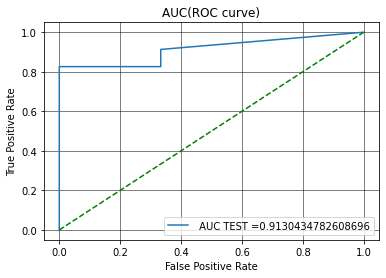

In [122]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix

occ_clinical = occ(labelled_scores_mean,0.67)

#train_fpr, train_tpr, tr_thresholds = roc_curve(y,methylation_scores_train)
test_fpr, test_tpr, te_thresholds = roc_curve(y_pre_TILs,occ_clinical)

plt.grid()

acc = []
for val in occ_clinical:
    acc.append(0) if val < 0.5 else acc.append(1)

print(accuracy_score(y_pre_TILs, acc))
print(confusion_matrix(acc, y_pre_TILs, labels = [1,0]))

#plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

<AxesSubplot:>

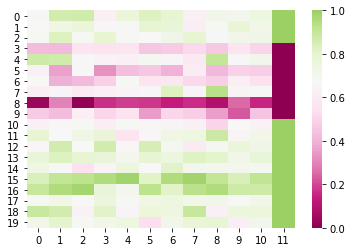

In [73]:
import seaborn as sns

sns.heatmap(matched_scores,cmap="PiYG",center=0.67)

In [74]:
matched_scores[:,-2]

array([0.74612095, 0.71617695, 0.72525416, 0.49896387, 0.71449438,
       0.47845663, 0.53955444, 0.68376896, 0.15080533, 0.44807029,
       0.63648122, 0.72098443, 0.73011472, 0.77710369, 0.69424952,
       0.91141895, 0.87877414, 0.71121665, 0.7646553 , 0.71274041])

In [75]:
occ = []

for row in matched_scores[:,:-2]:
    k = 0
    for item in row:
        if item >= 0.6: k+=1
            
    occ.append(k/10)

In [76]:
matched_occ = np.append(matched_scores, listify(occ), axis=1)

<AxesSubplot:>

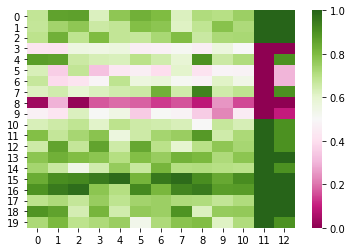

In [77]:
import seaborn as sns

sns.heatmap(matched_occ,cmap="PiYG",center=0.5)

In [172]:
from sklearn import svm
import shap
svm_explainer = shap.KernelExplainer(model.predict,X_train)
svm_shap_values = svm_explainer.shap_values(X_train)

  0%|          | 0/33 [00:00<?, ?it/s]

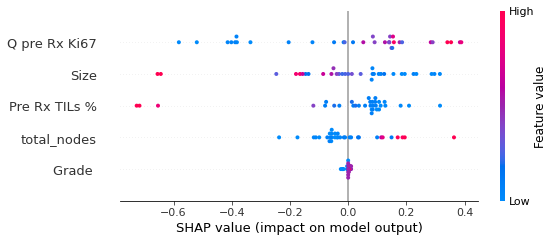

In [173]:
shap.summary_plot(svm_shap_values, X_train)

[0.15618429 0.13810494 0.2216837  0.03615442 0.14322914 0.02408497
 0.05159578 0.22896276]


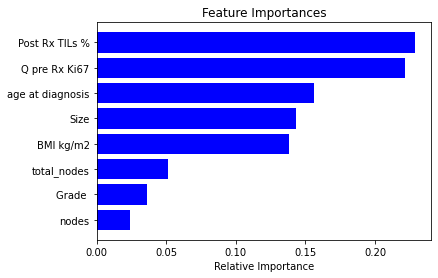

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=10)
rf.fit(X_train, y_train)  
print(rf.feature_importances_)
importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

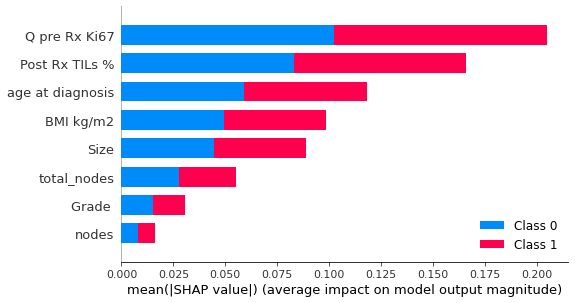

In [67]:
import shap

shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

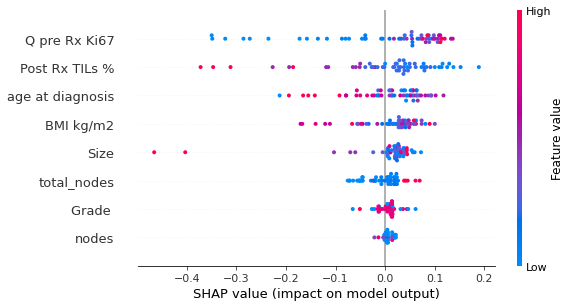

In [68]:
shap.summary_plot(shap_values[1], X_train, plot_type="dot")

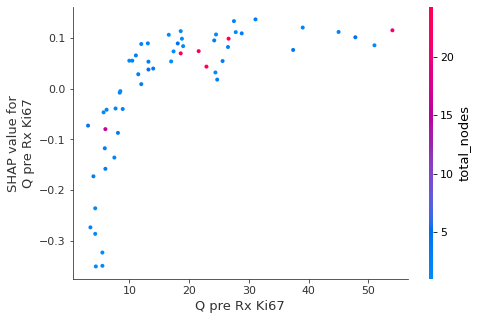

In [69]:
shap.dependence_plot("Q pre Rx Ki67", shap_values[1], X_train)

In [82]:
shap.initjs()
rf_explainer = shap.KernelExplainer(rf.predict, X_train)
rf_shap_values = rf_explainer.shap_values(X_train)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


  0%|          | 0/56 [00:00<?, ?it/s]

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

In [85]:
shap.force_plot(rf_explainer.expected_value, rf_shap_values[-1,:], X_train.iloc[-1,:])

In [86]:
shap.force_plot(rf_explainer.expected_value, rf_shap_values, X_train)

# Clean up the rest

In [294]:
import numpy as np

common = np.array(["MBN-5","MBN-41","MBN-1","MBN-17","MBN-44","MBN-2","MBN-11","MBN-31","MBN-47","MBN-42","MBN-8","MBN-20","MBN-25","MBN-26","MBN-6","MBN-16","MBN-18","MBN-23","MBN-28","MBN-39"])

In [305]:
index = []

for element in common:
    index.append(y.index.get_loc(element))
    
common_pred = []
for i in index:
    common_pred.append(y_pred[i])

In [296]:
common_true = [1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]

In [300]:
poor = []
poor_pred = []
for sample,acc_pred in zip(y_true,acc):
    if sample == 0:
        poor.append(sample)
        poor_pred.append(acc_pred)

In [301]:
print(accuracy_score(poor,poor_pred))

0.5217391304347826


In [1]:
from sklearn import metrics

combined_pred = [0.5235,0.6536,0.8254,0.2749,0.6750,0.7115,0.4795,0.6158,0.0794,0.8000,0.9448,1,0.7151,0.5228,0.6496,0.6671,0.8811,0.8986,0.5571,0.9603]

fpr, tpr, _ = metrics.roc_curve(common_true,  common_pred)
auc = metrics.roc_auc_score(common_true, common_pred)
plt.plot(fpr,tpr,label="Combined GBC, auc="+str(round(auc,4)))
plt.legend(loc=4)
plt.show()

NameError: name 'common_true' is not defined

In [274]:
common_pred

[0.49362844309023746,
 0.5757826461945031,
 0.6449823490733136,
 0.5313109630283519,
 0.6673521767493794,
 0.6489399994454149,
 0.7291343623562819,
 0.6315064239250886,
 0.7116092473124739,
 0.5,
 0.6603122863219346,
 0.7027111990201643,
 0.6700674659428512,
 0.7246656987852779,
 0.5458926319011222,
 0.7204929306426285,
 0.645348441451801,
 0.5849435562815282,
 0.6396110781625499,
 0.5715296544420235]

In [148]:
from matplotlib.colors import ListedColormap

def plot_decision_function(data,c,model):

    h = .02  # step size in the mesh

    figure = plt.figure(figsize=(27, 9))

    x_min, x_max = data[:, 0].min() - .5, data[:, 0].max() + .5
    y_min, y_max = data[:, 1].min() - .5, data[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    plt.scatter(data[:, 0], data[:, 1], c=c, cmap=cm_bright)
    plt.show()

In [200]:
from interpret.glassbox import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from interpret import show

# We have to transform categorical variables to use Logistic Regression and Decision Tree
#X_enc = pd.get_dummies(X, prefix_sep='.')

X_enc = X

#X_enc = X_enc.loc[:,['Q post Rx Ki67', 'Grade ', 'nodes', 'total_nodes']]

feature_names = list(X_enc.columns)

y_true, y_pred = [],[]

seed = 1

skf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=seed)
for train_index, test_index in skf.split(X_enc, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_enc, X_test_enc = X_enc.to_numpy()[train_index], X_enc.to_numpy()[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print(y_test)

    lr = LogisticRegression(random_state=seed, feature_names=feature_names, penalty='l2', solver='sag')
    lr.fit(X_train_enc, y_train)
    
    #lr_global = lr.explain_global(name='Logistic Regression')
    #show(lr_global)
    
    preds = lr.predict_proba(X_test_enc)[:,1]
    for true, pred in zip(y_test,preds):
        y_true.append(true)
        y_pred.append(pred)
    
print(roc_auc_score(y_true,y_pred))
print(average_precision_score(y_true,y_pred))

TRAIN: [ 1  2  3  4  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25 27 28 29
 30 31 32 33 34 35 36 37 39 41 43 45 47 48 49 50 51 53 54 56 57 58 59 60
 61 62] TEST: [ 0  5  6  8 24 26 38 40 42 44 46 52 55]
MBN-49    1
MBN-58    1
MBN-59    0
MBN-61    0
MBN-85    0
MBN-88    1
MBN-23    1
MBN-24    1
MBN-25    1
MBN-28    1
MBN-30    1
MBN-2     0
MBN-11    0
Name: endocrine response, dtype: int64
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 31 32 33 34 35 36 37 38 40 41 42 43 44 46 51 52 55 57 58 59
 60 61] TEST: [27 29 30 39 45 47 48 49 50 53 54 56 62]
MBN-89    1
MBN-93    0
MBN-95    1
MBN-19    1
MBN-26    1
MBN-33    1
MBN-34    1
MBN-39    1
MBN-40    1
MBN-3     0
MBN-9     0
MBN-17    0
MBN-47    0
Name: endocrine response, dtype: int64
TRAIN: [ 0  1  2  4  5  6  8 10 11 13 14 16 17 20 21 22 23 24 25 26 27 28 29 30
 31 33 34 37 38 39 40 41 42 44 45 46 47 48 49 50 51 52 53 54 55 56 57 59
 60 62] TEST: [ 3  7  9 12 15 18 19 32 35

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [246]:
from interpret.glassbox import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score
from interpret import show

# We have to transform categorical variables to use Logistic Regression and Decision Tree

X_enc = X

feature_names = list(X_enc.columns)

y_true, y_pred = [],[]

seed = 1

skf = StratifiedKFold(n_splits= 5, shuffle=True, random_state=seed)
for train_index, test_index in skf.split(X_enc, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_enc, X_test_enc = X_enc.to_numpy()[train_index], X_enc.to_numpy()[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print(y_test)

    lr = ExplainableBoostingClassifier(random_state=seed, feature_names = feature_names, n_jobs=-1, interactions=20)
    lr.fit(X_train_enc, y_train)
    
    lr_global = lr.explain_global(name='Logistic Regression')
    show(lr_global)
    
    preds = lr.predict_proba(X_test_enc)[:,1]
    for true, pred in zip(y_test,preds):
        y_true.append(true)
        y_pred.append(pred)
    
print(roc_auc_score(y_true,y_pred))
print(average_precision_score(y_true,y_pred))

TRAIN: [ 1  2  3  4  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25 27 28 29
 30 31 32 33 34 35 36 37 39 41 43 45 47 48 49 50 51 53 54 56 57 58 59 60
 61 62] TEST: [ 0  5  6  8 24 26 38 40 42 44 46 52 55]
MBN-49    1
MBN-58    1
MBN-59    0
MBN-61    0
MBN-85    0
MBN-88    1
MBN-23    1
MBN-24    1
MBN-25    1
MBN-28    1
MBN-30    1
MBN-2     0
MBN-11    0
Name: endocrine response, dtype: int64


<!-- http://127.0.0.1:7001/140546628123040/ -->

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 31 32 33 34 35 36 37 38 40 41 42 43 44 46 51 52 55 57 58 59
 60 61] TEST: [27 29 30 39 45 47 48 49 50 53 54 56 62]
MBN-89    1
MBN-93    0
MBN-95    1
MBN-19    1
MBN-26    1
MBN-33    1
MBN-34    1
MBN-39    1
MBN-40    1
MBN-3     0
MBN-9     0
MBN-17    0
MBN-47    0
Name: endocrine response, dtype: int64


<!-- http://127.0.0.1:7001/140546703702576/ -->

TRAIN: [ 0  1  2  4  5  6  8 10 11 13 14 16 17 20 21 22 23 24 25 26 27 28 29 30
 31 33 34 37 38 39 40 41 42 44 45 46 47 48 49 50 51 52 53 54 55 56 57 59
 60 62] TEST: [ 3  7  9 12 15 18 19 32 35 36 43 58 61]
MBN-54    0
MBN-60    1
MBN-62    0
MBN-67    1
MBN-71    1
MBN-76    0
MBN-78    1
MBN-5     1
MBN-16    1
MBN-15    1
MBN-27    1
MBN-31    0
MBN-44    0
Name: endocrine response, dtype: int64


<!-- http://127.0.0.1:7001/140546703603408/ -->

TRAIN: [ 0  1  3  5  6  7  8  9 12 13 15 17 18 19 22 23 24 26 27 28 29 30 31 32
 34 35 36 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 60 61 62] TEST: [ 2  4 10 11 14 16 20 21 25 33 37 59]
MBN-52    0
MBN-55    1
MBN-63    1
MBN-65    1
MBN-70    0
MBN-72    1
MBN-79    0
MBN-80    1
MBN-86    1
MBN-6     1
MBN-18    1
MBN-42    0
Name: endocrine response, dtype: int64


<!-- http://127.0.0.1:7001/140546702128896/ -->

TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 14 15 16 18 19 20 21 24 25 26 27 29
 30 32 33 35 36 37 38 39 40 42 43 44 45 46 47 48 49 50 52 53 54 55 56 58
 59 61 62] TEST: [ 1 13 17 22 23 28 31 34 41 51 57 60]
MBN-50    0
MBN-68    1
MBN-77    1
MBN-82    1
MBN-84    1
MBN-91    0
MBN-1     1
MBN-8     1
MBN-20    1
MBN-41    1
MBN-29    0
MBN-45    0
Name: endocrine response, dtype: int64


<!-- http://127.0.0.1:7001/140548786610288/ -->

0.8483695652173914
0.8998336535330855


In [101]:
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
X.loc[:,"Post Rx TILs %"] = est.fit_transform(X.loc[:,"Post Rx TILs %"].to_numpy().reshape(-1,1))

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X_stool = pd.read_csv('all_data/post_stool.csv', index_col = 0)
y_stool = X_stool["Response"]
print(y_stool.value_counts())
X_stool = X_stool.drop("Response",1)

# Select informative features
#X_stool = X_stool[["f__Lachnospiraceae","c__Coriobacteriia","s__Lachnospira_pectinoschiza","g__Lachnospira","s__Ruminococcus_bicirculans","f__Clostridiaceae","g__Clostridium","s__Roseburia_hominis","g__Butyricicoccus","s__Butyricicoccus_pullicaecorum","g__Actinomyces","o__Actinomycetales","f__Actinomycetaceae","s__Alistipes_onderdonkii"]]

X = X.drop("MBN-3")
y = y.drop("MBN-3")

X = X.drop("MBN-27")
y = y.drop("MBN-27")

X = X.drop("MBN-52")
y = y.drop("MBN-52")

# Find missing values

index = X_stool.index.str.replace("_","-")
meta_index = [x[:-1] for x in index]
list(set(X.index).symmetric_difference(set(meta_index)))

X_stool.index = meta_index
X = X.reindex(meta_index)

X_clinical = pd.merge(X,X_stool,on=X.index)
X_clinical.index = X_clinical.loc[:,"key_0"]
X_clinical.index.name = None
X = X_clinical.drop("key_0",1)

seed = 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed, stratify=y)

1    39
0    21
Name: Response, dtype: int64


In [531]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

X_oral = pd.read_csv('all_data/post_oral.csv', index_col = 0)
y_oral = X_oral["Response"]
print(y_oral.value_counts())
X_oral = X_oral.drop("Response",1)

# Select informative features
#X_oral = X_oral[["g__Aggregatibacter","s__Streptococcus_sanguinis","o__Selenomonadales","f__Selenomonadaceae","g__Selenomonas","s__Actinomyces_naeslundii","s__Prevotella_oulorum","s__Selenomonas_noxia","s__Leptotrichia_hofstadii","s__Leptotrichia_sp_oral_taxon_879","s__Dialister_invisus","s__Prevotella_maculosa","s__Leptotrichia_sp_oral_taxon_498"]]

X = X.drop("MBN-49")
y = y.drop("MBN-49")

X = X.drop("MBN-52")
y = y.drop("MBN-52")

# Find missing values

index = X_oral.index.str.replace("_","-")
meta_index = [x[:-3] for x in index]
list(set(X.index).symmetric_difference(set(meta_index)))

X_oral.index = meta_index
X = X.reindex(meta_index)

X_clinical = pd.merge(X,X_oral,on=X.index)
X_clinical.index = X_clinical.loc[:,"key_0"]
X_clinical.index.name = None
X = X_clinical.drop("key_0",1)

seed = 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

1    39
0    22
Name: Response, dtype: int64


In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

## Explore the dataset

In [141]:
from interpret import show
from interpret.data import ClassHistogram

hist = ClassHistogram().explain_data(X, y, name = 'Train Data')
show(hist)

<!-- http://127.0.0.1:7001/139644707756832/ -->

In [142]:
X_train.shape

(44, 8)

## Train the Explainable Boosting Machine (EBM)

In [143]:
from interpret.glassbox import ExplainableBoostingClassifier, LogisticRegression, ClassificationTree, DecisionListClassifier

ebm = ExplainableBoostingClassifier(random_state=1, n_jobs=-1)
ebm.fit(X_train, y_train)   #Works on dataframes and numpy arrays

ExplainableBoostingClassifier(feature_names=['age at diagnosis', 'BMI kg/m2',
                                             'Q pre Rx Ki67', 'Grade ', 'Size',
                                             'nodes', 'total_nodes',
                                             'Post Rx TILs %',
                                             'BMI kg/m2 x Q pre Rx Ki67',
                                             'Q pre Rx Ki67 x Post Rx TILs %',
                                             'Q pre Rx Ki67 x Size',
                                             'age at diagnosis x Q pre Rx Ki67',
                                             'age at diagnosis x Size',
                                             'Size x Post Rx TILs %',
                                             'age at diagnosis x BMI kg/m2',
                                             'Grade  x total_nodes',
                                             'total_nodes x Post Rx TILs %',
                                          

In [144]:
X

,age at diagnosis,BMI kg/m2,Q pre Rx Ki67,Grade,Size,nodes,total_nodes,Post Rx TILs %
MBN-49,55,20.90,54.0,3,35.0,1,20,5.0
MBN-50,66,25.70,4.3,1,16.0,1,1,20.0
MBN-52,70,39.10,14.0,2,15.0,1,4,10.0
MBN-54,51,24.22,51.0,2,11.0,0,1,10.0
MBN-55,59,24.77,47.8,2,35.0,2,5,10.0
...,...,...,...,...,...,...,...,...
MBN-31,66,35.30,17.0,2,9.0,0,1,20.0
MBN-42,61,24.40,5.5,2,8.0,0,1,2.0
MBN-45,73,30.50,8.1,1,7.0,0,3,10.0
MBN-44,69,27.00,13.2,2,20.0,1,5,2.0


In [145]:
y

MBN-49    1
MBN-50    0
MBN-52    0
MBN-54    0
MBN-55    1
         ..
MBN-31    0
MBN-42    0
MBN-45    0
MBN-44    0
MBN-47    0
Name: endocrine response, Length: 63, dtype: int64

## Global Explanations: What the model learned overall

In [146]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

<!-- http://127.0.0.1:7001/139642636001536/ -->

## Local Explanations: How an individual prediction was made

In [147]:
ebm_local = ebm.explain_local(X_test, y_test, name='EBM')
show(ebm_local)

<!-- http://127.0.0.1:7001/139644706249936/ -->

## Evaluate EBM performance

In [148]:
from interpret.perf import ROC

ebm_perf = ROC(ebm.predict_proba).explain_perf(X_test, y_test, name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7001/139644704236352/ -->

## Let's test out a few other Explainable Models

In [194]:
from interpret.glassbox import LogisticRegression, ClassificationTree

seed = 2

# We have to transform categorical variables to use Logistic Regression and Decision Tree
X_enc = pd.get_dummies(X, prefix_sep='.')
feature_names = list(X_enc.columns)
X_train_enc, X_test_enc, y_train, y_test = train_test_split(X_enc, y, test_size=0.3, random_state=seed, stratify=y)

lr = LogisticRegression(random_state=seed, feature_names=feature_names, penalty='l2', solver='sag')
lr.fit(X_train_enc, y_train)

tree = ClassificationTree()
tree.fit(X_train_enc, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [195]:
# no_meta = [[20,21,10.9,60,90],[40,25,93,30,90],[2,30,17.1,5,60],[2,12,13.5,0,1],[15,11,26.4,10,100]]

# X_test = pd.DataFrame(no_meta, columns = X_enc.columns)
# y_test = [0,0,0,0,0]

## Compare performance using the Dashboard

In [196]:
from interpret.perf import ROC

lr_perf = ROC(lr.predict_proba).explain_perf(X_test_enc, y_test, name='Logistic Regression')
tree_perf = ROC(tree.predict_proba).explain_perf(X_test_enc, y_test, name='Classification Tree')

show(lr_perf)
show(tree_perf)
show(ebm_perf)

<!-- http://127.0.0.1:7001/140546707500096/ -->

<!-- http://127.0.0.1:7001/140546700483456/ -->

<!-- http://127.0.0.1:7001/140546629957712/ -->

In [197]:
lr_local = lr.explain_local(X_test, y_test, name='LR')
show(lr_local)

<!-- http://127.0.0.1:7001/140546701215584/ -->

In [198]:
tree_local = tree.explain_local(X_test_enc[:5], y_test[:5], name='Tree')
show(tree_local)

<!-- http://127.0.0.1:7001/140546701188592/ -->

## Glassbox: All of our models have global and local explanations

In [67]:
lr_global = lr.explain_global(name='Logistic Regression')
tree_global = tree.explain_global(name='Classification Tree')

show(lr_global)
show(tree_global)
show(ebm_global)

<!-- http://127.0.0.1:7129/139664143779920/ -->

<!-- http://127.0.0.1:7129/139664143781792/ -->

NameError: name 'ebm_global' is not defined

## Dashboard: look at everything at once

In [150]:
# Do everything in one shot with the InterpretML Dashboard by passing a list into show

show([hist, lr_global, lr_perf, tree_global, tree_perf, ebm_global, ebm_perf], share_tables=True)

<!-- http://127.0.0.1:7954/140513202297472/ -->
 Open in new window